## Access this Notebook
You can launch this notebook in the US GHG Center JupyterHub by clicking the link below. If you are a new user, you should first sign up for the hub by filling out this [**request form**](https://docs.google.com/forms/d/e/1FAIpQLSdai8otCdrVQzJgev8mjDhzKyCg7jcrB3UeTXNHoCiaMKrkaQ/viewform) and providing the required information. 


Access the [**GOSAT-based Top-down Total and Natural Methane Emissions**](https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/gosat-based-ch4budget-yeargrid-v1_User_Notebook.html) notebook in the US GHG Center JupyterHub. 

## Table of Contents
- [Data Summary and Application](#data-summary-and-application)
- [Approach](#approach)
- [About the Data](#about-the-data)
- [Install the Required Libraries](#install-the-required-libraries)
- [Query the STAC API](#query-the-stac-api)
- [Visual Comparison Across Time Periods](#visual-comparison-across-time-periods)
- [Map Out Selected Tiles](#map-out-selected-tiles)
- [Calculate Zonal Statistics](#calculate-zonal-statistics)
- [Time-Series Analysis](#time-series-analysis)
- [Summary](#summary)

## Data Summary and Application
- **Spatial coverage**: Global
- **Spatial resolution**: 4° x 5°
- **Temporal extent**: 2010 - 2022
- **Temporal resolution**: Annual
- **Unit**: Teragrams of methane per yea
- **Utility**: Climate Research

For more, visit the [GOSAT-based Top-down Total and Natural Methane Emissions](https://earth.gov/ghgcenter/data-catalog/gosat-based-ch4budget-yeargrid-v1) data overview page.  

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the gridded methane emissions data product.
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json `endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

   

## About the Data
#### GOSAT-based Top-down Total and Natural Methane Emissions 

The NASA Carbon Monitoring System Flux (CMS-Flux) team analyzed remote sensing observations from Japan’s Greenhouse gases Observing SATellite (GOSAT) to produce the global Committee on Earth Observation Satellites (CEOS) CH₄ Emissions data product. They used an analytic Bayesian inversion approach and the GEOS-Chem global chemistry transport model to quantify annual methane (CH₄) emissions and their uncertainties at a spatial resolution of 1° by 1° and then projected these to each country for 2019.

For more information regarding this dataset, please visit the [GOSAT-based Top-down Total and Natural Methane Emissions](https://earth.gov/ghgcenter/data-catalog/gosat-based-ch4budget-yeargrid-v1) data overview page.

## Terminology
Navigating data via the GHGC API, you will encounter terminology that is different from browsing in a typical filesystem. We'll define some terms here which are used throughout this notebook.
- `catalog`:    All datasets available at the `/stac` endpoint
- `collection`: A specific dataset, e.g. GOSAT-based Top-down Total and Natural Methane Emissions
- `item`:       One granule in the dataset, e.g. one annual file of fluxes
- `asset`:      A variable available within the granule, e.g. anthropogenic methane emissions
- `STAC API`:   **Sp**atio**T**emporal **A**sset **C**atalogs - Endpoint for fetching metadata about available collections
- `Raster API`: Endpoint for fetching data, for imagery and statistics

## Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

In [1]:
# Import the following libraries
# For fetching from the Raster API
import requests
# For making maps
import folium
import folium.plugins
from folium import Map, TileLayer
# For talking to the STAC API
from pystac_client import Client
# For working with data
import pandas as pd
# For making time series
import matplotlib.pyplot as plt
# For formatting date/time data
import datetime
# Custom functions for working with GHGC data via the API
import ghgc_utils

## Query the STAC API
The libraries above allow better execution of a query in the GHG Center **Spatio Temporal Asset Catalog (STAC)** Application Programming Interface (API), where the granules for this collection are stored. You will learn the functionality of each library throughout the notebook.

### STAC API Collection Names

Now, you must fetch the dataset from the **STAC API** by defining its associated STAC API collection ID as a variable. The collection ID, also known as the **collection name**, for the GOSAT-based Top-down Total and Natural Methane Emissions dataset is **gosat-based-ch4budget-yeargrid-v1***

**You can find the collection name of any dataset on the GHGC data portal by navigating to the dataset landing page within the data catalog. The collection name is the last portion of the dataset landing page's URL, and is also listed in the pop-up box after clicking "ACCESS DATA."*

In [2]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# Please use the collection name similar to the one used in STAC collection.

# Name of the collection for gosat budget methane. 
collection_name = "gosat-based-ch4budget-yeargrid-v1"

In [3]:
# Using PySTAC client
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'pystac' library makes an HTTP request
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(collection_name)

# Print the properties of the collection to the console
collection

<CollectionClient id=gosat-based-ch4budget-yeargrid-v1>

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2010 to December 2022. By looking at the `dashboard:time density`, we observe that the data is annual over that time period.

In [4]:
items = list(collection.get_items())  # Convert the iterator to a list
print(f"Found {len(items)} items")

Found 13 items


In [5]:
# Examining the first item in the collection
items[0]

<Item id=gosat-based-ch4budget-yeargrid-v1-2022>

In [6]:
# Restructure our items into a dictionary where keys are the datetime items; we can then query more easily by date/time, e.g. "2020"
items_dict = {item.properties["datetime"][:4]: item for item in collection.get_items()}

In [7]:
# Before we go further, let's pick which asset to focus on for the remainder of the notebook.
# For this collection, we'll focus on the posterior total methane emissions, or:
asset_name = "post-total"

# Create Maps Using Folium
You will now explore differences in methane emissions at two different date/times. You will visualize the outputs on a map using `folium`.

## Fetch Imagery from Raster API

Here we get information from the `Raster API` which we will add to our map in the next section.

In [8]:
# Specify two dates/times to visualize
dates = ['2010','2020']

In [9]:
first_date = items_dict[dates[0]]
# Extract collection name and item ID
collection_id = first_date.collection_id
item_id = first_date.id
# Isolate chosen asset
object = first_date.assets[asset_name]
# Load raster bands to obtain statistics
raster_bands = object.extra_fields.get("raster:bands", [{}])
# Print raster bands
print(raster_bands)

[{'scale': 1.0, 'nodata': -9999.0, 'offset': 0.0, 'sampling': 'area', 'data_type': 'float64', 'histogram': {'max': 6.551439731574392, 'min': -1.0882688201549864, 'count': 11, 'buckets': [2, 2966, 230, 61, 31, 9, 6, 3, 2, 2]}, 'statistics': {'mean': 0.15064792279767236, 'stddev': 0.48261592630870437, 'maximum': 6.551439731574392, 'minimum': -1.0882688201549864, 'valid_percent': 100.0}}]


In [10]:
# 
rescale_values = {
    "max": raster_bands[0].get("histogram", {}).get("max"),
    #"min": raster_bands[0].get("histogram", {}).get("min"),
    "min": -1*raster_bands[0].get("histogram", {}).get("max")
}

print(rescale_values)

{'max': 6.551439731574392, 'min': -6.551439731574392}


Now, you will pass the `item id`, `collection name`, `asset name`, and the `rescale_values` to the `Raster API` endpoint. This step is done twice, once for each date/time you want to visualize.

In [11]:
# Choose a color map for displaying the data
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "Spectral_r" 

In [12]:
# Make a GET request to retrieve information for the first date
# Note that the colormap needs to be all lowercase for this to work properly.
tile_1 = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map.lower()}"
    f"&rescale=-0,3" #{rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
tile_1

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/gosat-based-ch4budget-yeargrid-v1/items/gosat-based-ch4budget-yeargrid-v1-2010/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=post-total&color_formula=gamma+r+1.05&colormap_name=spectral_r&rescale=-0%2C3'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-182.5, -90.9777777777778, 177.5, 90.97777777777777],
 'center': [-2.5, -1.4210854715202004e-14, 0]}

In [13]:
first_date = items_dict[dates[1]]
# Extract collection name and item ID
collection_id = first_date.collection_id
item_id = first_date.id
# Make a GET request to retrieve information for the second date
tile_2 = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map.lower()}"
    f"&rescale=-0,3" #{rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
tile_1

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/gosat-based-ch4budget-yeargrid-v1/items/gosat-based-ch4budget-yeargrid-v1-2010/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=post-total&color_formula=gamma+r+1.05&colormap_name=spectral_r&rescale=-0%2C3'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-182.5, -90.9777777777778, 177.5, 90.97777777777777],
 'center': [-2.5, -1.4210854715202004e-14, 0]}

## Generate Map

In [14]:
# Set initial zoom and center of map
# Centre of map set via location=(latitude,longitude)
map_ = folium.plugins.DualMap(location=(25, -80), zoom_start=3)

# Map layer showing first date
map_layer_1 = TileLayer(
    tiles=tile_1["tiles"][0],
    attr="GHG",
    name=f"{dates[0]}",
    opacity=0.7,
    overlay=True,
)
map_layer_1.add_to(map_.m1)

# Mapy layer showing second date
map_layer_2 = TileLayer(
    tiles=tile_2["tiles"][0],
    attr="GHG",
    name=f"{dates[1]}",
    opacity=0.7,
    overlay=True,
)
map_layer_2.add_to(map_.m2)

# Add a layer control to switch between map layers
folium.LayerControl(collapsed=False).add_to(map_)

# Add colorbar
# We'll use a function from the'ghgc_utils' module create an HTML colorbar representation.
legend_html = ghgc_utils.generate_html_colorbar(color_map,rescale_values,label='tC/km2/year')

# Add colorbar to the map
map_.get_root().html.add_child(folium.Element(legend_html))

map_

## Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [15]:
# Texas, USA
aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                [-95, 29],
                [-95, 33],
                [-104, 33],
                [-104,29],
                [-95, 29]
            ]
        ],
        "type": "Polygon",
    },
}

In [16]:
# Check total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=300"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 13 items


In [19]:
%%time
stats = [ghgc_utils.generate_stats(item, aoi,asset_name) for item in items]

TypeError: generate_stats() takes 2 positional arguments but 3 were given

In [14]:
stats[0]

{'statistics': {'b1': {'min': 0.45840875428297767,
   'max': 2.563434123331244,
   'mean': 1.3501146985384829,
   'count': 1.9799998998641968,
   'sum': 2.6732269679113765,
   'std': 0.5669339642223294,
   'median': 1.0878720382884925,
   'majority': 0.45840875428297767,
   'minority': 0.45840875428297767,
   'unique': 6.0,
   'histogram': [[2, 0, 1, 0, 0, 2, 0, 0, 0, 1],
    [0.45840875428297767,
     0.6689112911878043,
     0.8794138280926309,
     1.0899163649974577,
     1.300418901902284,
     1.5109214388071108,
     1.7214239757119376,
     1.931926512616764,
     2.1424290495215907,
     2.352931586426417,
     2.563434123331244]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 6.0,
   'percentile_2': 0.45840875428297767,
   'percentile_98': 2.563434123331244}},
 'datetime': '2022-01-01T00:00:00+00:00'}

In [15]:
df = clean_stats(stats)
df = df.sort_values("datetime")
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
12,2010-01-01T00:00:00+00:00,0.522762,2.687274,1.615991,1.98,3.199662,0.718321,1.176316,0.522762,0.522762,6.0,"[[1, 0, 1, 1, 0, 1, 0, 0, 0, 2], [0.5227617384...",100.0,0.0,6.0,0.522762,2.687274,2010-01-01 00:00:00+00:00
11,2011-01-01T00:00:00+00:00,0.266725,2.235993,1.301970,1.98,2.577901,0.610951,0.960086,0.266725,0.266725,6.0,"[[1, 0, 1, 1, 0, 1, 0, 0, 1, 1], [0.2667253696...",100.0,0.0,6.0,0.266725,2.235993,2011-01-01 00:00:00+00:00
10,2012-01-01T00:00:00+00:00,0.380561,2.395962,1.422850,1.98,2.817244,0.630351,1.037681,0.380561,0.380561,6.0,"[[1, 0, 1, 1, 0, 0, 1, 0, 1, 1], [0.3805614366...",100.0,0.0,6.0,0.380561,2.395962,2012-01-01 00:00:00+00:00
9,2013-01-01T00:00:00+00:00,0.532251,2.535978,1.568220,1.98,3.105075,0.655252,1.170210,0.532251,0.532251,6.0,"[[1, 1, 0, 1, 0, 0, 1, 0, 0, 2], [0.5322511442...",100.0,0.0,6.0,0.532251,2.535978,2013-01-01 00:00:00+00:00
8,2014-01-01T00:00:00+00:00,0.450945,2.553213,1.479748,1.98,2.929900,0.578882,1.198123,0.450945,0.450945,6.0,"[[1, 1, 0, 1, 0, 0, 2, 0, 0, 1], [0.4509453464...",100.0,0.0,6.0,0.450945,2.553213,2014-01-01 00:00:00+00:00


In [58]:
%%time

df = ghgc_utils.generate_stats(items,aoi,url=RASTER_API_URL,asset=asset_name)

Generating stats...


TypeError: string indices must be integers, not 'str'

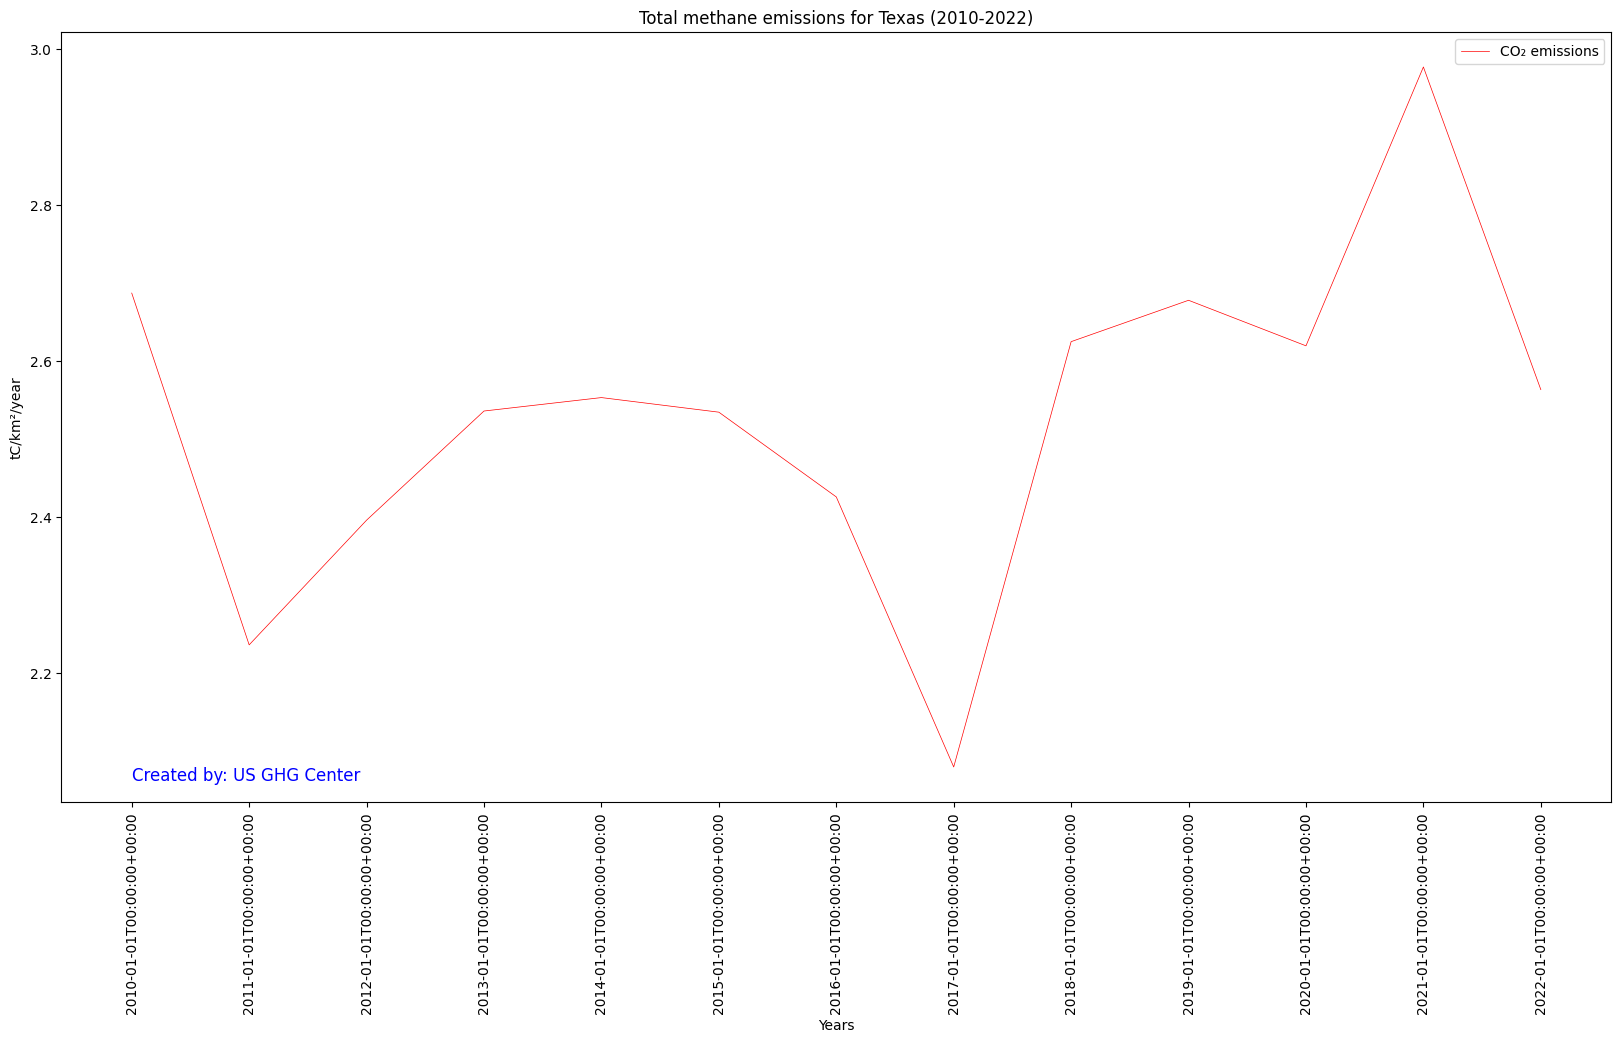

In [16]:
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(20, 10))

plt.plot(
    df["datetime"], # X-axis: sorted datetime
    df["max"], # Y-axis: maximum CO₂
    color="red", # Line color
    linestyle="-", # Line style
    linewidth=0.5, # Line width
    label="CO₂ emissions", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("tC/km²/year")
plt.xticks(rotation = 90)

# Insert title for the plot
plt.title("Total methane emissions for Texas (2010-2022)")

# Add data citation
plt.text(
    df["datetime"].iloc[0],           # X-coordinate of the text
    df["max"].min(),                  # Y-coordinate of the text
    # Text to be displayed
    "Created by: US GHG Center",      #example text            
    fontsize=12,                             # Font size
    horizontalalignment="left",              # Horizontal alignment
    verticalalignment="top",                 # Vertical alignment
    color="blue",                            # Text color
)


# Plot the time series
plt.show()

## Summary

In this notebook we have successfully completed the following steps for the STAC collection for the GOSAT-based Top-down Total and Natural Methane Emissions dataset.

1.  Install and import the necessary libraries
2.  Fetch the collection from STAC collections using the appropriate endpoints
3.  Count the number of existing granules within the collection
4.  Map the methane emission levels
5.  Generate zonal statistics for the area of interest (AOI)

If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform).